In [412]:
import pandas as pd
import ast
import re
import json
from sklearn import linear_model
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy import sparse

In [36]:
x = re.sub('l', 'h', 'hello my darling')
x

'hehho my darhing'

In [269]:
reviews = []
with open('reviews.txt', 'r', encoding='utf-8') as f:
    reviews = f.read()

reviews = re.sub('\]', '', reviews)
reviews = re.sub('\[', '', reviews)
reviews = re.sub('\n', '', reviews)
reviews = re.sub("'", '"', reviews)
reviews = re.sub('    ', ' ', reviews)
reviews = re.sub(' {', '{', reviews)
reviews = re.sub(' }', '}', reviews)
reviews = re.sub('{ ', '{', reviews)
reviews = re.sub('} ', '}', reviews)
reviews = re.sub('}  {', '}, {', reviews)
reviews = re.sub('}{', '}, {', reviews)
reviews = re.sub('id:', '"id":', reviews)
reviews = re.sub('userName:', '"userName":', reviews)
reviews = re.sub('userImage:', '"userImage":', reviews)
reviews = re.sub('date:', '"date":', reviews)
reviews = re.sub('url:', '"url":', reviews)
reviews = re.sub('score:', '"score":', reviews)
reviews = re.sub('title:', '"title":', reviews)
reviews = re.sub('text:', '"text":', reviews)
reviews = re.sub('replyDate:', '"replyDate":', reviews)
reviews = re.sub('replyText:', '"replyText":', reviews)
reviews = re.sub(': undefined', ': "undefined"', reviews)

In [270]:
review_strings = [r+'}' for r in reviews.split('},')]
review_strings[-1] = review_strings[-1][:-1]

In [274]:
review_list = []
for r in review_strings:
    try:
        review_list.append(json.loads(r))
    except:
        pass

In [275]:
len(review_list)

3972

In [279]:
review_text = [r['text'] for r in review_list]
review_dates = [r['date'] for r in review_list]
review_scores = [r['score'] for r in review_list]

In [385]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sdatta\AppData\Roaming\nltk_data...


True

In [536]:
sid = SentimentIntensityAnalyzer()

pscores = []
lens = []
for sentence in review_text:
    pscores.append(abs(sid.polarity_scores(sentence)['compound']))
    lens.append(np.log(len(sentence.split('.'))))
    
#pscores = np.reshape(pscores, [-1,1])

In [531]:
np.max(lens)

34

In [485]:
review_text_lim = review_text[np.array(np.where(np.array([len(x) for x in review_text]) < 500))]

TypeError: only integer scalar arrays can be converted to a scalar index

In [537]:
train_text, test_text, train_scores, test_scores, train_pscores, test_pscores, train_lens, test_lens = train_test_split(review_text, review_scores, pscores, lens, random_state=2)

cv = CountVectorizer(min_df=1, ngram_range=(0,5))
cv_train_sentences = cv.fit_transform(train_text)
cv_test_sentences = cv.transform(test_text)

train_pscore_sparse = sparse.csr_matrix(train_pscores)
train_pscore_int = sparse.csc_matrix.multiply(np.transpose(train_pscore_sparse), cv_train_sentences)
#stacked_train_sentences = sparse.hstack([cv_train_sentences, np.transpose(train_pscore_sparse), train_pscore_int])
stacked_train_sentences = sparse.hstack([cv_train_sentences, np.transpose(train_pscore_sparse), np.transpose(sparse.csr_matrix(train_lens))])


test_pscore_sparse = sparse.csr_matrix(test_pscores)
test_pscore_int = sparse.csc_matrix.multiply(np.transpose(test_pscore_sparse), cv_test_sentences)
#stacked_test_sentences = sparse.hstack([cv_test_sentences, np.transpose(test_pscore_sparse), test_pscore_int])
stacked_test_sentences = sparse.hstack([cv_test_sentences, np.transpose(test_pscore_sparse), np.transpose(sparse.csr_matrix(test_lens))])

In [507]:
np.transpose(train_lens).shape

(2979,)

In [504]:
np.transpose(train_pscores).shape

(2979,)

In [502]:
np.multiply(train_pscores, train_lens).shape

(2979,)

In [538]:
train_df = np.transpose(np.stack((train_pscores, train_lens, np.transpose(np.multiply(train_pscores, train_lens))), axis=0))
test_df = np.transpose(np.stack((test_pscores, test_lens, np.transpose(np.multiply(test_pscores, test_lens))), axis=0))

In [521]:
lm.coef_

array([ 1.13807138, -0.52746403,  0.08262148])

In [539]:
lm = linear_model.Ridge()
lm.fit(train_df, train_scores)
preds = lm.predict(test_df)
print(mean_squared_error(preds, test_scores))

1.4882213436746266


In [380]:
np.where(preds<=-1)

(array([974], dtype=int32),)

In [381]:
test_text[974]

'I had my old account for almost a year now. But I just bought a new phone and it didn"t let me log into my snap so I made a new one and I logged out today to give my friend to log in. And now I can"t log back on and my email is the same. I"m recieving email from you guys that someone is trying to log in, but that"s me and when I say to verify through email it"s says email not recognized. Fix it please asap.'

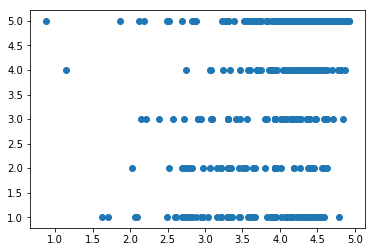

In [540]:
plt.scatter(preds, test_scores)
plt.show()

In [549]:
lr_base = LogisticRegression(C = 1, class_weight="balanced")
lr_base.fit(stacked_train_sentences, train_scores)
preds = lr_base.predict(stacked_test_sentences)
print(classification_report(test_scores, preds))

              precision    recall  f1-score   support

           1       0.47      0.61      0.53        99
           2       0.27      0.09      0.14        43
           3       0.35      0.25      0.29        79
           4       0.27      0.08      0.12        92
           5       0.83      0.94      0.88       680

   micro avg       0.73      0.73      0.73       993
   macro avg       0.44      0.39      0.39       993
weighted avg       0.68      0.73      0.70       993



In [301]:
cv_featurenames = cv.get_feature_names()


weightIndeces_con = np.argsort(lr_base.coef_[0])[:10]

In [302]:
for index in weightIndeces_con: 
    print(cv_featurenames[index])

love
awesome
great
good
cool
amazing
nice
best
love it
most
